In [ ]:
# SQR

%matplotlib inline
from matplotlib import pyplot as plt
import torch
import math

class QuantileLoss(torch.nn.Module):
    def __init__(self):
        super(QuantileLoss, self).__init__()

    def forward(self, yhat, y, tau):
        diff = yhat - y
        mask = (diff.ge(0).float() - tau).detach()
        return (mask * diff).mean()
    
def augment(x, tau=None):
    if tau is None:
        tau = torch.zeros(x.size(0), 1).fill_(0.5)
    elif type(tau) == float:
        tau = torch.zeros(x.size(0), 1).fill_(tau)
        
    return torch.cat((x, (tau - 0.5) * 12), 1)

def train_net(x, y, q="all"):
    net = torch.nn.Sequential(
            torch.nn.Linear(d + 1, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1))

    opt = torch.optim.Adam(net.parameters(),
                           1e-3,
                           weight_decay=1e-2)
    loss = QuantileLoss()

    for _ in range(10000):
        opt.zero_grad()
        if q == "all":
            taus = torch.rand(x.size(0), 1)
        else:
            taus = torch.zeros(x.size(0), 1).fill_(q)
        loss(net(augment(x, taus)), y, taus).backward()
        opt.step()
        
    return net


n = 1000
d = 5

x = torch.randn(n, d)
y = x[:, 0].view(-1, 1).mul(5).cos() + 0.3 * torch.randn(n, 1)

net = train_net(x, y, "all")
net_01 = train_net(x, y, 0.1)
net_05 = train_net(x, y, 0.5)
net_09 = train_net(x, y, 0.9)

x = torch.randn(n, d)
y = x[:, 0].view(-1, 1).mul(5).cos() + 0.3 * torch.randn(n, 1)
o = torch.sort(x[:, 0])[1]

plt.rc('text', usetex=True)
plt.rc('font', size=16)
plt.rc('text.latex', preamble=r'\usepackage{times}')
plt.figure(figsize=(15, 4))
plt.rc('font', family='serif')

plt.subplot(1, 4, 1)
plt.title("separate estimation")
plt.plot(x[o, 0].numpy(), y[o].detach().numpy(), '.')
plt.plot(x[o, 0].numpy(), net_01(augment(x[o], 0.1)).detach().numpy(), alpha=0.75, label="$\\tau_{0.1}$")
plt.plot(x[o, 0].numpy(), net_05(augment(x[o], 0.5)).detach().numpy(), alpha=0.75, label="$\\tau_{0.5}$")
plt.plot(x[o, 0].numpy(), net_09(augment(x[o], 0.9)).detach().numpy(), alpha=0.75, label="$\\tau_{0.9}$")
plt.legend()

plt.subplot(1, 4, 2)

plt.plot(x[o, 0].numpy(), (net_09(augment(x[o], 0.9)) - net_05(augment(x[o], 0.5))).detach().numpy(), alpha=0.75, label="$\\tau_{0.9} - \\tau_{0.5}$")
plt.plot(x[o, 0].numpy(), (net_05(augment(x[o], 0.5)) - net_01(augment(x[o], 0.1))).detach().numpy(), alpha=0.75, label="$\\tau_{0.5} - \\tau_{0.1}$")
plt.axhline(0, ls="--", color="gray")
plt.legend()

plt.subplot(1, 4, 3)
plt.title("joint estimation")
plt.plot(x[o, 0].numpy(), y[o].detach().numpy(), '.')
plt.plot(x[o, 0].numpy(), net(augment(x[o], 0.1)).detach().numpy(), alpha=0.75, label="$\\tau_{0.1}$")
plt.plot(x[o, 0].numpy(), net(augment(x[o], 0.5)).detach().numpy(), alpha=0.75, label="$\\tau_{0.5}$")
plt.plot(x[o, 0].numpy(), net(augment(x[o], 0.9)).detach().numpy(), alpha=0.75, label="$\\tau_{0.9}$")
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(x[o, 0].numpy(), (net(augment(x[o], 0.9)) - net(augment(x[o], 0.5))).detach().numpy(), alpha=0.75, label="$\\tau_{0.9} - \\tau_{0.5}$")
plt.plot(x[o, 0].numpy(), (net(augment(x[o], 0.5)) - net(augment(x[o], 0.1))).detach().numpy(), alpha=0.75, label="$\\tau_{0.9} - \\tau_{0.5}$")

plt.axhline(0, ls="--", color="gray")
plt.legend()

plt.tight_layout(0, 0, 0)
plt.savefig("joint_estimation.pdf")

In [ ]:
# MCQRNN

import tensorflow as tf
import numpy as np
from typing import Callable, Tuple, Union

### 🔹 1. 데이터 변환 (Data Transformation)
def _mcqrnn_transform(
    x: np.ndarray,
    taus: np.ndarray,
    y: Union[np.ndarray, None] = None,
) -> Tuple[np.ndarray, ...]:
    """
    데이터를 분위수 학습이 가능하도록 변환하는 함수
    """
    _len_taus = len(taus)
    _len_x = len(x)
    _len_data = _len_x * _len_taus

    x_trans = np.repeat(x, _len_taus, axis=0).astype("float32")
    taus_trans = np.tile(taus, _len_x).reshape((_len_data, 1)).astype("float32")
    if y is not None:
        y_trans = np.repeat(y, _len_taus, axis=0).astype("float32")
        y_trans = y_trans.reshape((_len_data, 1))
        return x_trans, y_trans, taus_trans
    else:
        return x_trans, taus_trans

class DataTransformer:
    """
    데이터 변환을 수행하는 클래스
    """
    def __init__(self, x: np.ndarray, taus: np.ndarray, y: Union[np.ndarray, None] = None):
        self.x = x
        self.y = y
        self.taus = taus
        self.x_trans, self.y_trans, self.tau_trans = _mcqrnn_transform(x=self.x, y=self.y, taus=self.taus)

    def __call__(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        return self.x_trans, self.y_trans, self.tau_trans

    def transform(self, x: np.ndarray, input_taus: np.ndarray) -> np.ndarray:
        input_taus = input_taus.astype("float32")
        return _mcqrnn_transform(x=x, taus=input_taus)

### 🔹 2. MCQRNN 신경망 레이어 정의
class McqrnnInputDense(tf.keras.layers.Layer):
    """
    입력층 (Input Layer) - 입력 데이터와 분위수 정보를 결합하는 역할
    """
    def __init__(self, out_features: int, activation: Callable, **kwargs):
        super(McqrnnInputDense, self).__init__(**kwargs)
        self.out_features = out_features
        self.activation = activation

    def build(self, input_shape):
        self.w_inputs = tf.Variable(tf.random.normal([input_shape[-1], self.out_features]), name="w_inputs")
        self.w_tau = tf.Variable(tf.random.normal([1, self.out_features]), name="w_tau")
        self.b = tf.Variable(tf.zeros([self.out_features]), name="b")

    def call(self, inputs, tau):
        outputs = (
            tf.matmul(inputs, self.w_inputs)
            + tf.matmul(tau, tf.exp(self.w_tau))
            + self.b
        )
        return self.activation(outputs)

class McqrnnDense(tf.keras.layers.Layer):
    """
    중간 은닉층 (Hidden Layer) - 분위수 정보를 학습
    """
    def __init__(self, dense_features: int, activation: Callable, **kwargs):
        super(McqrnnDense, self).__init__(**kwargs)
        self.dense_features = dense_features
        self.activation = activation

    def build(self, input_shape):
        self.w = tf.Variable(tf.random.normal([input_shape[-1], self.dense_features]), name="w")
        self.b = tf.Variable(tf.zeros([self.dense_features]), name="b")

    def call(self, inputs: np.ndarray):
        outputs = tf.matmul(inputs, tf.exp(self.w)) + self.b
        return self.activation(outputs)

class McqrnnOutputDense(tf.keras.layers.Layer):
    """
    출력층 (Output Layer) - 최종 예측값 생성
    """
    def __init__(self, **kwargs):
        super(McqrnnOutputDense, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w = tf.Variable(tf.random.normal([input_shape[-1], 1]), name="w")
        self.b = tf.Variable(tf.zeros([1]), name="b")

    def call(self, inputs: np.ndarray):
        outputs = tf.matmul(inputs, tf.exp(self.w)) + self.b
        return outputs

### 🔹 3. MCQRNN 모델 정의
class Mcqrnn(tf.keras.Model):
    """
    MCQRNN 신경망 모델
    """
    def __init__(self, out_features: int, dense_features: int, activation: Callable = tf.nn.relu, **kwargs):
        super(Mcqrnn, self).__init__(**kwargs)
        self.input_dense = McqrnnInputDense(out_features=out_features, activation=activation)
        self.dense = McqrnnDense(dense_features=dense_features, activation=activation)
        self.output_dense = McqrnnOutputDense()

    def call(self, inputs: np.ndarray, tau: np.ndarray):
        x = self.input_dense(inputs, tau)
        x = self.dense(x)
        outputs = self.output_dense(x)
        return outputs

### 🔹 4. 손실 함수 (Quantile Loss)
class TiltedAbsoluteLoss(tf.keras.losses.Loss):
    """
    핀볼 손실 함수 (Pinball Loss)
    """
    def __init__(self, tau: Union[np.ndarray, tf.Tensor], **kwargs):
        super(TiltedAbsoluteLoss, self).__init__(**kwargs)
        self._one = tf.cast(1, dtype=tau.dtype)
        self._tau = tf.cast(tau, dtype=tau.dtype)

    def call(self, y_true: Union[np.ndarray, tf.Tensor], y_pred: Union[np.ndarray, tf.Tensor]) -> tf.Tensor:
        error = y_true - y_pred
        _loss = tf.math.maximum(self._tau * error, (self._tau - self._one) * error)
        return tf.reduce_mean(_loss)

### 🔹 5. 학습 함수
@tf.function
def train_step(
    model: tf.keras.Model,
    inputs: np.ndarray,
    output: np.ndarray,
    tau: np.ndarray,
    loss_func: tf.keras.losses.Loss,
    optimizer: tf.keras.optimizers,
):
    """
    단일 학습 스텝 수행
    """
    with tf.GradientTape(persistent=True) as tape:
        predicted = model(inputs, tau)
        loss = loss_func(output, predicted)

    grad = tape.gradient(loss, model.weights)
    optimizer.apply_gradients(zip(grad, model.weights))
    return loss

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt

In [2]:
# 분위수 손실 함수 정의
class QuantileLoss(torch.nn.Module):
    def __init__(self):
        super(QuantileLoss, self).__init__()

    def forward(self, yhat, y, tau):
        diff = yhat - y
        mask = (diff.ge(0).float() - tau).detach()
        return (mask * diff).mean()

In [3]:
# 분위수 정보를 입력 데이터에 추가하는 함수 
def augment(x, tau=None):
    if tau is None:
        tau = torch.zeros(x.size(0), 1).fill_(0.5)
    elif type(tau) == float:
        tau = torch.zeros(x.size(0), 1).fill_(tau)
        
    return torch.cat((x, (tau - 0.5) * 12), 1)

In [4]:
# GNN 기반 모델 정의
class GNNQuantile(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNQuantile, self).__init__()
        self.conv1 = GCNConv(input_dim + 1, hidden_dim) # 분위수 정보 추가
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, edge_index, tau):
        tau = (tau - 0.5) * 12  # 분위수 정보 변환
        x = torch.cat((x, tau), dim=1)  # 분위수 정보를 노드 특징에 추가
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x

In [9]:
# GNN 훈련 함수
def train_gnn_multiple(x, y, edge_index, q='all'):
    input_dim = x.shape[1]
    hidden_dim = 128
    output_dim = 1
    
    model = GNNQuantile(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
    loss_fn = QuantileLoss()
    
    for _ in range(10000):
        optimizer.zero_grad()
        
        if q == 'all':
            taus = torch.rand(x.size(0), 1)
        else:
            taus = torch.full((x.size(0), 1), q)
            
        loss = loss_fn(model(x, edge_index, taus), y, taus)
        loss.backward()
        optimizer.step()
        
    return model

def train_gnn_single(x, y, edge_index, q=0.5):
    input_dim = x.shape[1]
    hidden_dim = 128
    output_dim = 1
    
    model = GNNQuantile(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
    loss_fn = QuantileLoss() 
    
    for _ in range(10000):
        optimizer.zero_grad()
        
        taus = torch.full((x.size(0), 1), q)  # 특정 분위수만 학습
        loss = loss_fn(model(x, edge_index, taus), y, taus)
        
        loss.backward()
        optimizer.step()
        
    return model

# 신뢰구간을 학습하는 GNN 모델
def train_gnn_ci(x, y, edge_index, ci=0.9):
    input_dim = x.shape[1]
    hidden_dim = 128
    output_dim = 1
    
    model = GNNQuantile(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
    loss_fn = QuantileLoss()
    
    # 신뢰구간에 맞는 분위수 계산
    lower_tau = (1 - ci) / 2  # 예: 90% 신뢰구간이면 하위 5% (0.05)
    upper_tau = 1 - (1 - ci) / 2  # 예: 90% 신뢰구간이면 상위 95% (0.95)
    
    for _ in range(10000):
        optimizer.zero_grad()

        taus = torch.cat([
            torch.full((x.size(0) // 2, 1), lower_tau),  # 하위 분위수
            torch.full((x.size(0) - x.size(0) // 2, 1), upper_tau)  # 상위 분위수
        ], dim=0)

        loss = loss_fn(model(x, edge_index, taus), y, taus)
        
        loss.backward()
        optimizer.step()
        
    return model

In [10]:
# 그래프 데이터 생성
num_nodes = 100
input_dim = 6
hidden_dim = 128
output_dim = 1

x = torch.randn(num_nodes, input_dim) # 노드 특징
edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2)) # 랜덤 그래프
y = torch.randn(num_nodes, 1) # 타겟 값

In [11]:
# 개별 분위수 모델 학습
net_005 = train_gnn_single(x, y, edge_index, q=0.05)
net_095 = train_gnn_single(x, y, edge_index, q=0.95)

# 신뢰 분위수 모델 학습
net_joint = train_gnn_ci(x, y, edge_index, ci=0.9) 

In [14]:
# 개별 학습된 모델을 사용한 예측값
predictions_sep = {
    0.05: net_005(x, edge_index, torch.full((num_nodes, 1), 0.05)).detach().numpy(),
    0.95: net_095(x, edge_index, torch.full((num_nodes, 1), 0.95)).detach().numpy(),
}

# 조인트 학습된 모델을 사용한 예측값
predictions_joint = {
    tau: net_joint(x, edge_index, torch.full((num_nodes, 1), tau)).detach().numpy()
    for tau in [0.05, 0.95]
}

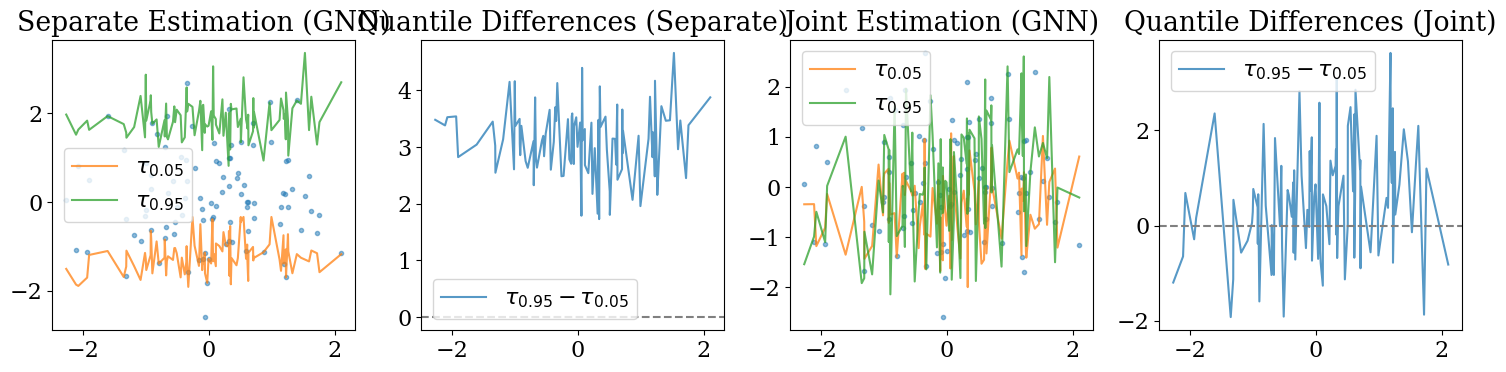

In [18]:
# 정렬된 노드 인덱스
o = torch.sort(x[:, 0])[1]

# 시각화
plt.figure(figsize=(15, 4))
plt.rc('font', size=16)
plt.rc('font', family='serif')

# (1) 개별 학습된 분위수 모델 (Separate Estimation)
plt.subplot(1, 4, 1)
plt.title("Separate Estimation (GNN)")
plt.plot(x[o, 0].numpy(), y[o].numpy(), '.', alpha=0.5)
for tau in [0.05, 0.95]:
    plt.plot(x[o, 0].numpy(), predictions_sep[tau][o], alpha=0.75, label=f"$\\tau_{{{tau}}}$")
plt.legend()

# (2) 분위수 차이 시각화 (Separate Estimation)
plt.subplot(1, 4, 2)
plt.title("Quantile Differences (Separate)")
plt.plot(x[o, 0].numpy(), (predictions_sep[0.95] - predictions_sep[0.05])[o], alpha=0.75, label="$\\tau_{0.95} - \\tau_{0.05}$")
plt.axhline(0, ls="--", color="gray")
plt.legend()

# (3) 조인트 학습된 분위수 모델 (Joint Estimation)
plt.subplot(1, 4, 3)
plt.title("Joint Estimation (GNN)")
plt.plot(x[o, 0].numpy(), y[o].numpy(), '.', alpha=0.5)
for tau in [0.05, 0.95]:
    plt.plot(x[o, 0].numpy(), predictions_joint[tau][o], alpha=0.75, label=f"$\\tau_{{{tau}}}$")
plt.legend()

# (4) 분위수 차이 시각화 (Joint Estimation)
plt.subplot(1, 4, 4)
plt.title("Quantile Differences (Joint)")
plt.plot(x[o, 0].numpy(), (predictions_joint[0.95] - predictions_joint[0.05])[o], alpha=0.75, label="$\\tau_{0.95} - \\tau_{0.05}$")
plt.axhline(0, ls="--", color="gray")
plt.legend()

# 결과 저장 및 표시
plt.tight_layout()
# plt.savefig("gnn_joint_vs_separate_estimation.pdf")
plt.show()

In [ ]:
# 개별 학습된 분위수 모델의 문제점
## 불안정한 예측 (overfitiing 및 generalization 문제)
## 특정 분위수에서만 모델을 학습하면, 다른 분위수에 대한 일괄된 정보 공유가 없음 -> 예측이 불안정해짐
## 개별 학습 시 데이터가 적을 경우 각 분위수 모델이 과적합되기 쉬움
## 해결책: 다중 분위수 학습 방식 적용하여 모든 분위수를 함께 학습

In [ ]:
# 다중 분위수 학습 방식에서는 분위수를 함께 학습하므로 개별학습보다 안정적인 예측이 가능하지만, 훈련 과정에서 여전히 분위수 교차가 발생할 수 있음
# 이를 해결하기 위해 벌점 함수를 추가하여 분위수 교차를 방지할 수 있음

In [25]:
# 분위수 교차 방지 벌점 함수
def penalty_relu(q1, q2, epsilon=1e-6):
    return torch.mean(torch.relu(q1 - q2 + epsilon))  # 분위수가 교차하면 벌점 부여

def penalty_squared(q1, q2):
    return torch.mean((q1 - q2) ** 2)  # 교차할수록 큰 패널티 적용

def penalty_huber(q1, q2, delta=1.0):
    diff = q1 - q2
    return torch.mean(torch.where(torch.abs(diff) < delta, 0.5 * diff**2, delta * (torch.abs(diff) - 0.5 * delta)))

def penalty_log_barrier(q1, q2, epsilon=1e-6):
    return -torch.mean(torch.log(q2 - q1 + epsilon))  # 교차가 심할수록 강력한 제약

In [26]:
# 신뢰구간 학습 (벌점 포함)
def train_gnn_ci_penalized(x, y, edge_index, ci=0.9, penalty_type="relu", penalty_weight=1.0):
    input_dim = x.shape[1]
    hidden_dim = 128
    output_dim = 1
    
    model = GNNQuantile(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
    loss_fn = QuantileLoss()
    
    # 벌점 함수 선택
    penalty_functions = {
        "relu": penalty_relu,
        "squared": penalty_squared,
        "huber": penalty_huber,
        "log_barrier": penalty_log_barrier
    }
    penalty_fn = penalty_functions.get(penalty_type, penalty_relu)  # 기본값: ReLU 벌점

    # 신뢰구간에 맞는 분위수 설정
    lower_tau = (1 - ci) / 2  # 예: 90% 신뢰구간이면 5% 분위수
    upper_tau = 1 - (1 - ci) / 2  # 예: 90% 신뢰구간이면 95% 분위수
    
    for _ in range(10000):
        optimizer.zero_grad()

        taus_lower = torch.full((x.size(0), 1), lower_tau)
        taus_upper = torch.full((x.size(0), 1), upper_tau)

        y_lower = model(x, edge_index, taus_lower)
        y_upper = model(x, edge_index, taus_upper)

        loss_lower = loss_fn(y_lower, y, taus_lower)
        loss_upper = loss_fn(y_upper, y, taus_upper)

        # 분위수 교차 방지 벌점 적용
        penalty = penalty_weight * penalty_fn(y_lower, y_upper)

        loss = loss_lower + loss_upper + penalty

        loss.backward()
        optimizer.step()
        
    return model

In [31]:
net_005 = train_gnn_single(x, y, edge_index, q=0.05)
net_095 = train_gnn_single(x, y, edge_index, q=0.95)
net_joint = train_gnn_ci(x, y, edge_index, ci=0.8) 
net_joint_penalized_1 = train_gnn_ci_penalized(x, y, edge_index, penalty_type = 'relu', ci=0.8) 
net_joint_penalized_2 = train_gnn_ci_penalized(x, y, edge_index, penalty_type = 'squared', ci=0.8) 
net_joint_penalized_3 = train_gnn_ci_penalized(x, y, edge_index, penalty_type = 'huber', ci=0.8) 
net_joint_penalized_4 = train_gnn_ci_penalized(x, y, edge_index, penalty_type = 'log_barrier', ci=0.8) 

In [32]:
predictions_sep = {
    0.05: net_005(x, edge_index, torch.full((num_nodes, 1), 0.05)).detach().numpy(),
    0.95: net_095(x, edge_index, torch.full((num_nodes, 1), 0.95)).detach().numpy(),
}

predictions_joint = {
    tau: net_joint(x, edge_index, torch.full((num_nodes, 1), tau)).detach().numpy()
    for tau in [0.05, 0.95]
}

predictions_joint_penalized_1 = {
    tau: net_joint_penalized_1(x, edge_index, torch.full((num_nodes, 1), tau)).detach().numpy()
    for tau in [0.05, 0.95]
}

predictions_joint_penalized_2 = {
    tau: net_joint_penalized_2(x, edge_index, torch.full((num_nodes, 1), tau)).detach().numpy()
    for tau in [0.05, 0.95]
}

predictions_joint_penalized_3 = {
    tau: net_joint_penalized_3(x, edge_index, torch.full((num_nodes, 1), tau)).detach().numpy()
    for tau in [0.05, 0.95]
}

predictions_joint_penalized_4 = {
    tau: net_joint_penalized_4(x, edge_index, torch.full((num_nodes, 1), tau)).detach().numpy()
    for tau in [0.05, 0.95]
}

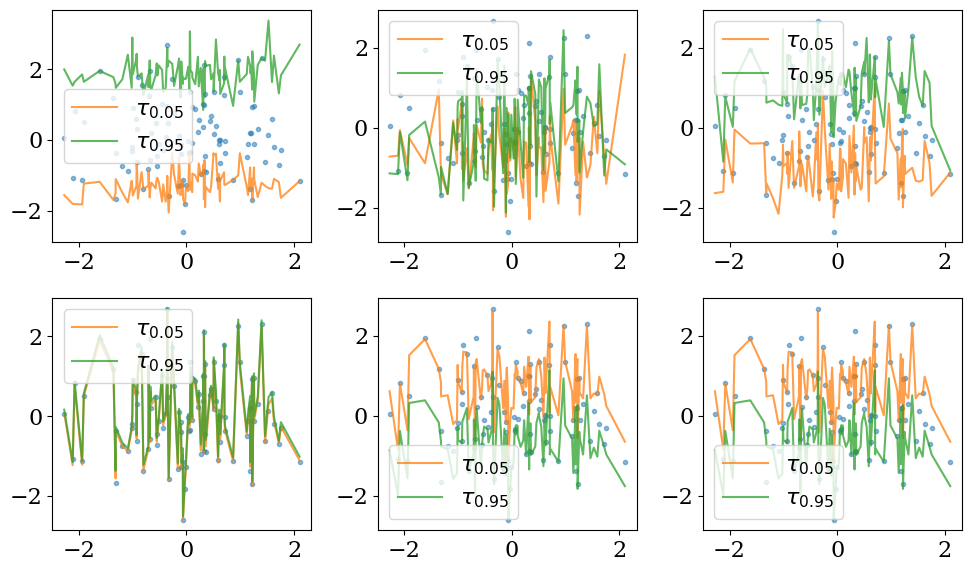

In [36]:
# 정렬된 노드 인덱스
o = torch.sort(x[:, 0])[1]

# 시각화
plt.figure(figsize=(10, 6))
plt.rc('font', size=16)
plt.rc('font', family='serif')

plt.subplot(2, 3, 1)
plt.plot(x[o, 0].numpy(), y[o].numpy(), '.', alpha=0.5)
for tau in [0.05, 0.95]:
    plt.plot(x[o, 0].numpy(), predictions_sep[tau][o], alpha=0.75, label=f"$\\tau_{{{tau}}}$")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(x[o, 0].numpy(), y[o].numpy(), '.', alpha=0.5)
for tau in [0.05, 0.95]:
    plt.plot(x[o, 0].numpy(), predictions_joint[tau][o], alpha=0.75, label=f"$\\tau_{{{tau}}}$")
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(x[o, 0].numpy(), y[o].numpy(), '.', alpha=0.5)
for tau in [0.05, 0.95]:
    plt.plot(x[o, 0].numpy(), predictions_joint_penalized_1[tau][o], alpha=0.75, label=f"$\\tau_{{{tau}}}$")
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(x[o, 0].numpy(), y[o].numpy(), '.', alpha=0.5)
for tau in [0.05, 0.95]:
    plt.plot(x[o, 0].numpy(), predictions_joint_penalized_2[tau][o], alpha=0.75, label=f"$\\tau_{{{tau}}}$")
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(x[o, 0].numpy(), y[o].numpy(), '.', alpha=0.5)
for tau in [0.05, 0.95]:
    plt.plot(x[o, 0].numpy(), predictions_joint_penalized_4[tau][o], alpha=0.75, label=f"$\\tau_{{{tau}}}$")
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(x[o, 0].numpy(), y[o].numpy(), '.', alpha=0.5)
for tau in [0.05, 0.95]:
    plt.plot(x[o, 0].numpy(), predictions_joint_penalized_4[tau][o], alpha=0.75, label=f"$\\tau_{{{tau}}}$")
plt.legend()

# 결과 저장 및 표시
plt.tight_layout()
# plt.savefig("gnn_joint_vs_separate_estimation.pdf")
plt.show()

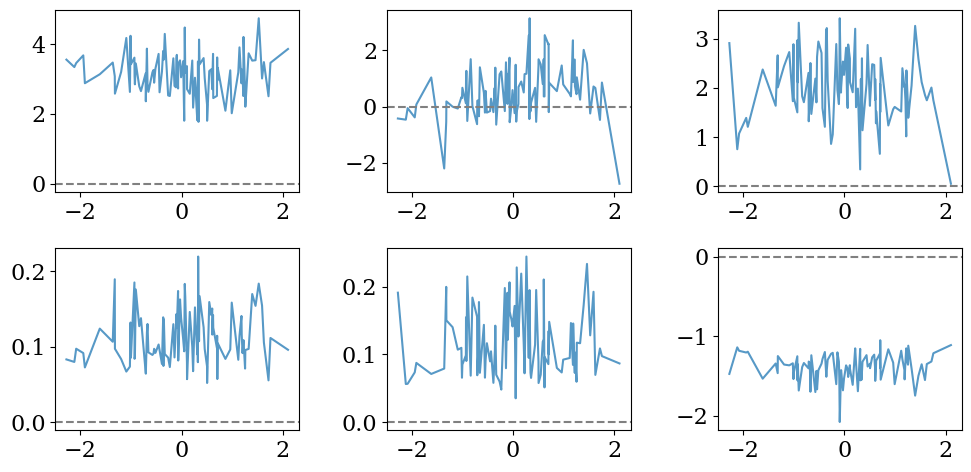

In [38]:
o = torch.sort(x[:, 0])[1]
plt.figure(figsize=(10, 5))
plt.rc('font', size=16)
plt.rc('font', family='serif')

plt.subplot(2, 3, 1)
plt.plot(x[o, 0].numpy(), (predictions_sep[0.95] - predictions_sep[0.05])[o], alpha=0.75, label="$\\tau_{0.95} - \\tau_{0.05}$")
plt.axhline(0, ls="--", color="gray")
# plt.legend()

plt.subplot(2, 3, 2)
plt.plot(x[o, 0].numpy(), (predictions_joint[0.95] - predictions_joint[0.05])[o], alpha=0.75, label="$\\tau_{0.95} - \\tau_{0.05}$")
plt.axhline(0, ls="--", color="gray")
# plt.legend()

plt.subplot(2, 3, 3)
plt.plot(x[o, 0].numpy(), (predictions_joint_penalized_1[0.95] - predictions_joint_penalized_1[0.05])[o], alpha=0.75, label="$\\tau_{0.95} - \\tau_{0.05}$")
plt.axhline(0, ls="--", color="gray")
# plt.legend()

plt.subplot(2, 3, 4)
plt.plot(x[o, 0].numpy(), (predictions_joint_penalized_2[0.95] - predictions_joint_penalized_2[0.05])[o], alpha=0.75, label="$\\tau_{0.95} - \\tau_{0.05}$")
plt.axhline(0, ls="--", color="gray")
# plt.legend()

plt.subplot(2, 3, 5)
plt.plot(x[o, 0].numpy(), (predictions_joint_penalized_3[0.95] - predictions_joint_penalized_3[0.05])[o], alpha=0.75, label="$\\tau_{0.95} - \\tau_{0.05}$")
plt.axhline(0, ls="--", color="gray")
# plt.legend()

plt.subplot(2, 3, 6)
plt.plot(x[o, 0].numpy(), (predictions_joint_penalized_4[0.95] - predictions_joint_penalized_4[0.05])[o], alpha=0.75, label="$\\tau_{0.95} - \\tau_{0.05}$")
plt.axhline(0, ls="--", color="gray")
# plt.legend()

# 결과 저장 및 표시
plt.tight_layout()
# plt.savefig("gnn_joint_vs_separate_estimation.pdf")
plt.show()